# **Tesla Stock - Prediction**

## **Import Library**

In [19]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## **Data Loading**

In [ ]:
# Mengambil dataset dari Kaggle
path = kagglehub.dataset_download("varpit94/tesla-stock-data-updated-till-28jun2021")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\M Ilham Ramadhan\.cache\kagglehub\datasets\varpit94\tesla-stock-data-updated-till-28jun2021\versions\9


In [ ]:
# Mengecek nama file
files = os.listdir(path)
print(files)

['TSLA.csv']


In [ ]:
# Import dataset dengan datetime sebagai index
df = pd.read_csv(f'{path}/TSLA.csv', parse_dates=True, index_col='Date')

**Insight**

Dataset ini merupakan data historis harga saham Tesla Inc. pada tanggal 29 Juni 2010 hingga 24 Maret 2022 dan sering digunakan untuk eksperimen time series forecasting maupun analisis pasar saham. Dataset mencerminkan pergerakan harga saham Tesla dari waktu ke waktu yang sangat berguna untuk membangun model prediksi berbasis deep learning.

Dataset ini berisi **2956 entri** dan terdiri dari beberapa kolom utama yang merepresentasikan harga saham Tesla pada tiap harinya, termasuk volume perdagangan. Berikut adalah penjelasan masing-masing variabel.

- **Date** : Tanggal transaksi saham menjadi indeks utama dalam prediksi time series.

- **Open** : Harga pembukaan saham pada awal perdagangan hari tersebut.

- **High** : Harga tertinggi saham pada hari itu.

- **Low** : Harga terendah saham pada hari itu.

- **Close** : Harga penutupan saham pada akhir sesi perdagangan.

- **Adj Close** : Harga penutupan yang telah disesuaikan dengan dividen dan pemecahan saham.

- **Volume** : Jumlah saham Tesla yang diperdagangkan pada hari tersebut.

Dalam proyek ini, fokus utama prediksi adalah pada kolom **`Close`**, yaitu harga penutupan karena kolom ini paling sering digunakan dalam analisis tren dan pengambilan keputusan investasi.

## **Exploratory Data Analysis**

### Deskripsi Variabel

In [ ]:
# Mengecek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [ ]:
# Statistik deskriptif dari dataset
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [ ]:
# Mengecek dataset untuk melihat beberapa baris pertama
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [ ]:
# Mengecek dataset untuk melihat beberapa baris terakhir
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400
2022-03-24,1009.729980,1024.489990,988.799988,1013.919983,1013.919983,22901900


**Insight**

Dataset ini memiliki 2.956 baris data dengan 6 fitur yang semuanya bertipe numerik, dan tidak terdapat missing value. Dataset ini juga sudah menggunakan indeks bertipe waktu (`DatetimeIndex`) yang mencakup periode dari tanggal 2010-06-29 hingga 2022-03-24.

Seluruh fitur bersifat numerik dan memiliki jumlah data yang lengkap (non-null 100%). Fitur-fitur tersebut menjelaskan harga dan volume transaksi saham Tesla pada setiap tanggal.

Berdasarkan informasi statistik deskriptif tersebut dapat disimpulkan:

- Harga saham Tesla mengalami peningkatan yang sangat besar dari nilai minimum di sekitar $3 hingga mencapai maksimum lebih dari $1.200, menunjukkan fluktuasi harga yang ekstrem.

- Volume perdagangan juga sangat bervariasi, dari hanya 592.500 saham per hari hingga mencapai lebih dari 304 juta saham.

- Nilai rata-rata Volume sekitar 31 juta saham per hari, menandakan saham ini tergolong aktif diperdagangkan.

### Menangani Missing Value

In [9]:
# Cek missing value
print(f'Missing Value :\n{df.isnull().sum()}')

Missing Value :
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


**Insight**

Berdasarkan hasil tersebut, tidak ada missing value pada dataset sehingga tidak perlu dilakukan penanganan missing value imputasi maupun penghapusan baris.

### Menangani Data Duplikat

In [10]:
# Cek duplkasi data
print(f'Duplicate Data :\n{df.duplicated().sum()}')

Duplicate Data :
0


**Insight**

Berdasarkan hasil pengecekan duplikasi data, didapatkan bahwa tidak terdapat duplikat data pada dataset sehingga tidak diperlukan penghapusan data dan bisa dilanjutkan ke analisis selanjutnya.

### Data Visualisasi

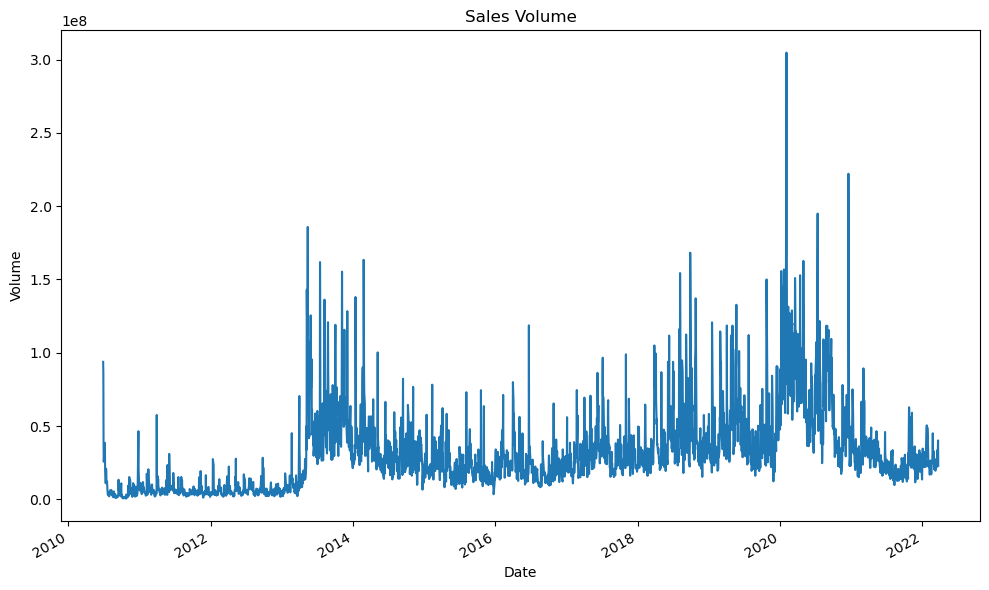

In [ ]:
# Visualisasi volume penjualan
plt.figure(figsize=(10, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Sales Volume")
plt.tight_layout()
plt.show()

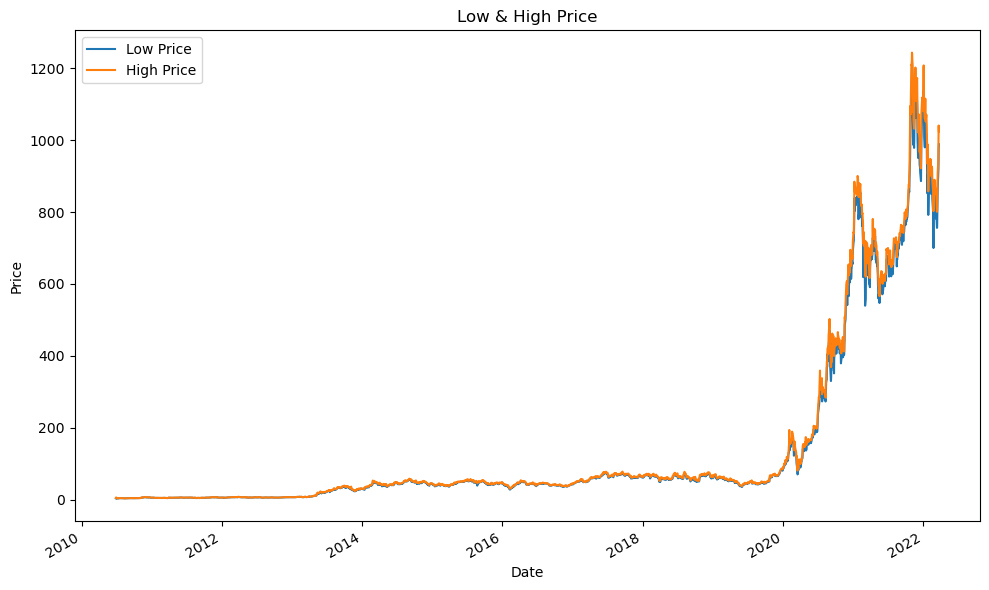

In [ ]:
# Visualisasi harga saham harian tertinggi dan terendah
plt.figure(figsize=(10, 6))
df['Low'].plot()
df['High'].plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.title("Low & High Price")
plt.legend(['Low Price', 'High Price'])
plt.tight_layout()
plt.show()

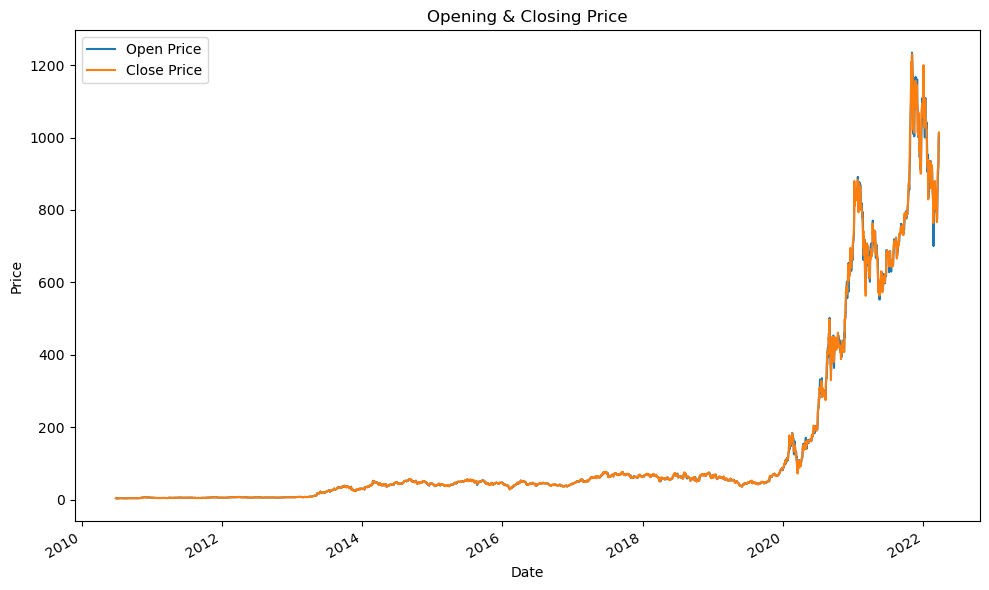

In [ ]:
# Visualisasi harga pembukaan dan penutupan saham
plt.figure(figsize=(10, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.title("Opening & Closing Price")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

In [ ]:
# Visualisasi candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])
fig.update_layout(title='Candlestick Chart', xaxis_rangeslider_visible=False)
fig.show()

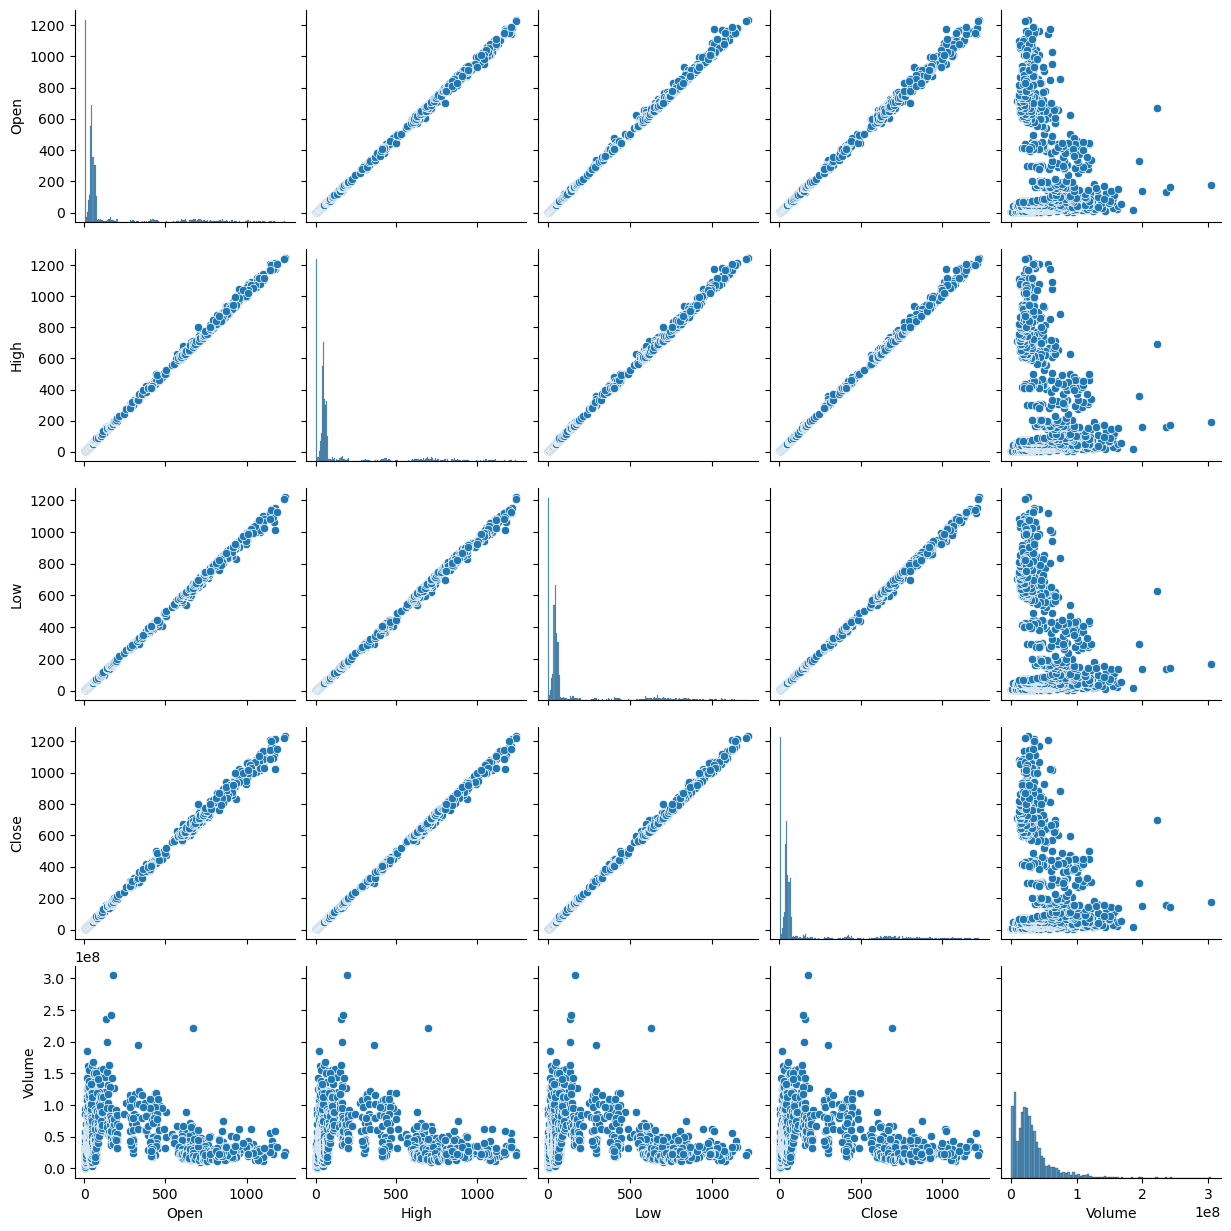

In [ ]:
# Visualisai pairplot untuk melihat hubungan antar fitur
sns.pairplot(df[['Open', 'High', 'Low', 'Close', 'Volume']])

**Insight**

- **Volume Penjualan Saham dari Waktu ke Waktu**

Visualisasi volume penjualan menunjukkan bahwa volume penjualan saham relatif stabil dari tahun 2010 hingga 2013, kemudian meningkat tajam pada periode 2013–2014 yang mengindikasikan meningkatnya minat pasar. Lonjakan paling signifikan terjadi pada tahun 2020, kemungkinan besar akibat peristiwa besar seperti pandemi yang memengaruhi sentimen pasar secara global. Setelah itu, volume cenderung fluktuatif namun dengan tren menurun hingga 2022. Pola ini menunjukkan bahwa volume perdagangan sangat dipengaruhi oleh peristiwa ekonomi makro dan perilaku investor terhadap ketidakpastian pasar.

- **Harga Saham Harian Tertinggi dan Terendah**

Harga tertinggi dan terendah harian menunjukkan tren yang stabil dan cukup sempit sebelum tahun 2020, dengan harga berada di bawah $100. Namun, mulai tahun 2020 terjadi lonjakan harga yang drastis, di mana harga mencapai puncak baru, menunjukkan fase pertumbuhan eksponensial saham. Pada saat yang sama, jarak antara harga tertinggi dan terendah harian juga melebar, mengindikasikan volatilitas pasar yang tinggi. Hal ini mencerminkan periode yang sangat aktif secara spekulatif, di mana harga bergerak cepat dalam satu hari perdagangan.

- **Harga Saham Pembukaan dan Penutupan Harian**  

Harga pembukaan dan penutupan saham sangat berkorelasi erat dan menunjukkan pergerakan yang hampir bersamaan sepanjang waktu. Sebelum tahun 2020, harga saham cenderung rendah dan stabil, namun setelah itu terjadi tren kenaikan yang tajam. Kedekatan nilai antara harga pembukaan dan penutupan mengindikasikan kestabilan harga dalam intraday trading, yang berarti tidak banyak fluktuasi dalam satu hari. Namun, tren kenaikan yang berkelanjutan menunjukkan adanya sentimen positif dan minat beli yang kuat dari investor, terutama selama masa pertumbuhan perusahaan atau peristiwa global tertentu.

- **Candlestick Chart**

Grafik candlestick ini menunjukkan tren harga saham dari tahun 2011 hingga awal 2022. Terlihat bahwa harga saham mulai mengalami peningkatan yang signifikan sejak tahun 2020, dengan volatilitas yang juga semakin tinggi. Hal ini kemungkinan disebabkan oleh sentimen pasar yang kuat atau perubahan signifikan pada kondisi perusahaan atau pasar global.

- **Hubungan antar Variabel Harga Saham dan Volume**

Berdasarkan grafik di atas, tampak bahwa harga pembukaan, tertinggi, terendah, dan penutupan saham memiliki korelasi yang sangat kuat, yang ditunjukkan oleh pola diagonal yang sangat rapat. Sementara itu, volume transaksi memiliki hubungan yang lebih lemah terhadap harga, meskipun terlihat bahwa volume cenderung menurun saat harga meningkat drastis. Ini bisa mengindikasikan bahwa pergerakan harga yang besar sering terjadi dalam kondisi volume yang tidak selalu tinggi, atau adanya aksi spekulatif pada saat-saat tertentu.

## **Data Preparation**

### Feature Selection

In [12]:
# Mengambil hanya kolom harga penutupan
df = df["Close"]
df = pd.DataFrame(df)

# Mengubah ke dalam format array
data = df.values

**Insight**

Langkah awal Data Preparation adalah memilih kolom fitur yang akan digunakan untuk prediksi. Karena fokus prediksi adalah harga penutupan (`Close`), maka hanya kolom tersebut yang dipilih dari dataset. Dengan langkah ini, dataset difokuskan hanya pada variabel target yaitu harga penutupan saham Tesla.

### Feature Scalling

In [13]:
# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

**Insight**

Karena model deep learning sensitif terhadap skala data, maka dilakukan normalisasi data menggunakan `MinMaxScaler`. Proses ini mengubah nilai menjadi rentang 0 hingga 1. Normalisasi membantu model untuk berkonvergensi lebih cepat dan menghasilkan prediksi yang lebih akurat.

### Data Splitting

In [14]:
# Menentukan panjang urutan data historis
sequence = 30

# Hitung ukuran data
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size

# Split data
train_data = scaled_data[:train_size, 0:1]
test_data = scaled_data[train_size-sequence:, 0:1]

**Insight**

Data Splitting adalah pembagian dataset menjadi data latih dan data uji. Proporsi yang digunakan adalah 80% untuk training dan 20% untuk testing. Karena ini adalah data time series, pemisahan dilakukan tanpa pengacakan (non-random split) untuk menjaga urutan waktu. Perlu diperhatikan bahwa `test_data` dimulai dari `train_size - sequence` untuk memastikan adanya overlap window sebagai konteks prediksi pada data uji.

### Sequence

In [15]:
# Membuat sliding window untuk data training
X_train = []
y_train = []

for i in range(sequence, len(train_data)):
    X_train.append(train_data[i-sequence:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
# Membuat sliding window untuk data testing
X_test = []
y_test = []

for i in range(sequence, len(test_data)):
    X_test.append(test_data[i-sequence:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [17]:
# Cek ukuran data
X_train.shape , y_train.shape
X_test.shape , y_test.shape

((592, 30, 1), (592,))

**Insight**

Model seperti LSTM/GRU membutuhkan input berbentuk urutan (sequence), bukan data statis. Oleh karena itu, dibuatlah sliding window sepanjang 30 data terakhir untuk memprediksi data berikutnya. Pada output ukuran `X_train` dan `X_test` memiliki bentuk 3 dimensi `(samples, timesteps, features)` yang sesuai dengan input untuk model sekuensial. Pada data Training didapatkan ukuran `X_train` dan `y_train` dengan bentuk `((2334, 30, 1), (2334,))`, sementara pada Data Testing `X_test` dan `y_test` berukuran `((592, 30, 1), (592,))`

## **Long Short-Term Memory (LSTM)**

### Modelling

In [18]:
# Arsitektur model LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(32, return_sequences=False))
model_lstm.add(Dense(16))
model_lstm.add(Dense(1))

model_lstm.summary()

c:\Users\M Ilham Ramadhan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Kompilasi model
model_lstm.compile(
    loss='mse',
    optimizer='Adam',
    metrics=['mae']
)

In [20]:
# Pelatihan model dengan Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [21]:
# Melatih model
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping], 
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 2.1415e-04 - mae: 0.0100 - val_loss: 1.1598e-05 - val_mae: 0.0027
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.9055e-06 - mae: 0.0018 - val_loss: 1.1989e-05 - val_mae: 0.0027
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.5733e-06 - mae: 0.0017 - val_loss: 1.1092e-05 - val_mae: 0.0026
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.6003e-06 - mae: 0.0019 - val_loss: 9.9623e-06 - val_mae: 0.0024
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0149e-06 - mae: 0.0016 - val_loss: 1.0625e-05 - val_mae: 0.0026
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.8690e-06 - mae: 0.0017 - val_loss: 1.0985e-05 - val_mae: 0.0026
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3102e-06 - mae: 0.0017 - val_loss: 8.5483e-06 - val_mae: 0.0023
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6477e-06 - mae: 0.0016 - val_loss: 8.9850e-06 - val_mae: 0.0023


**Insight**

Setelah model LSTM selesai dibangun, langkah selanjutnya adalah kompilasi dan pelatihan (training). Proses ini sangat penting karena menentukan bagaimana model belajar dari data dan mengevaluasi performanya.

- Kompilasi model bertujuan untuk mengatur fungsi loss (kerugian), algoritma optimisasi, dan metrik evaluasi.

- Training model adalah proses di mana model mempelajari pola dari data pelatihan selama beberapa epoch (putaran), untuk meminimalkan nilai loss.

Selanjutnya, digunakan teknik Early Stopping untuk menghentikan pelatihan jika model sudah tidak mengalami perbaikan pada data validasi. Ini sangat berguna untuk menghindari overfitting, yaitu kondisi ketika model terlalu cocok terhadap data latih dan tidak mampu generalisasi ke data baru.

Tahapan terakhir adalah model dilatih menggunakan data training. Berikut adalah kode untuk melatih data training dengan menggunakan model yang sudah didefinisikan. Dengan proses ini, model LSTM dapat belajar dari data historis saham dan siap untuk digunakan dalam tahap evaluasi maupun prediksi.

### Evaluation

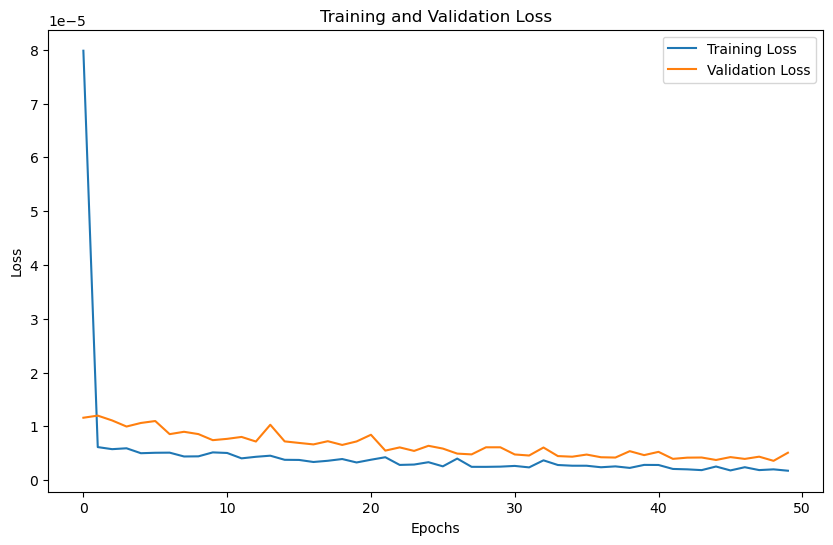

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [23]:
lstm_pred = model_lstm.predict(X_test)

lstm_pred = scaler.inverse_transform(lstm_pred)
lstm_test = scaler.inverse_transform(y_test.reshape(-1, 1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [24]:
print("Mean Square Error :", round(mean_squared_error(lstm_test, lstm_pred), 2))
print("Mean Absolute Error :", round(mean_absolute_error(lstm_test, lstm_pred), 2))
print("Root Mean Square Error :", np.sqrt(np.mean(lstm_test - lstm_pred)**2).round(2))
print("Mean Absolute Percentage Error :", round(mean_absolute_percentage_error(lstm_test, lstm_pred), 2))

Mean Square Error : 3840.42
Mean Absolute Error : 45.48
Root Mean Square Error : 43.4
Mean Absolute Percentage Error : 0.07


In [25]:
train = df.iloc[:train_size , 0:1]
test = df.iloc[train_size: , 0:1]
test['LSTM Prediction'] = lstm_pred

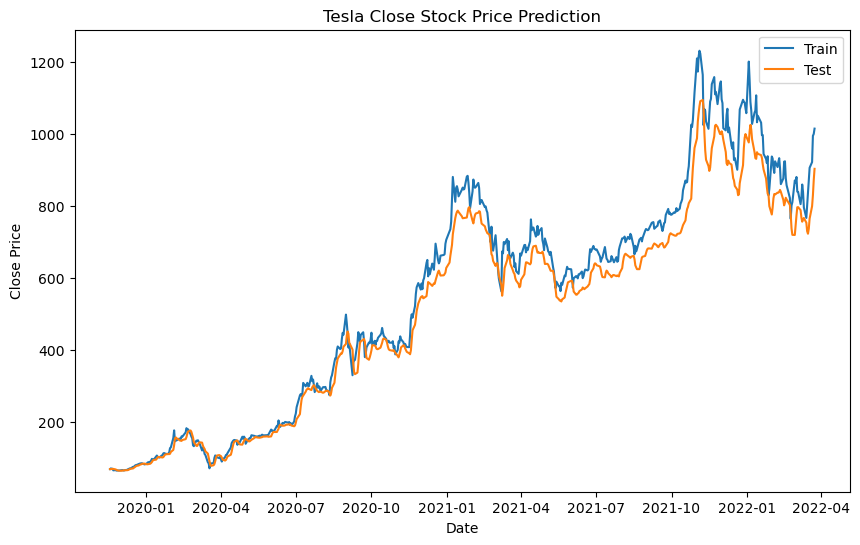

In [26]:
plt.figure(figsize= (10, 6))
plt.title('Tesla Close Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(test['Close'])
plt.plot(test['LSTM Prediction'])
plt.legend(['Train', 'Test', 'LSTM Prediction'])

**Insight**

Visualisasi antara loss dan validation loss menunjukkan bahwa model LSTM memiliki tren loss yang menurun dan stabil, menandakan proses pelatihan berjalan dengan baik tanpa indikasi overfitting yang signifikan.

MSE mengukur rata-rata dari kuadrat selisih antara nilai aktual dan nilai prediksi. Nilai sebesar 3840.42 menunjukkan bahwa terdapat beberapa prediksi yang meleset cukup jauh dari nilai sebenarnya, karena MSE sensitif terhadap outlier. Semakin besar nilai ini, semakin besar pula deviasi ekstrem yang terjadi.

MAE mengukur rata-rata dari kesalahan absolut antara hasil prediksi dan data aktual. Dengan nilai MAE sebesar 45.48, dapat disimpulkan bahwa secara rata-rata model LSTM memiliki deviasi sekitar ±45.48 unit dari nilai sebenarnya. Ini memberikan gambaran langsung dan intuitif mengenai seberapa jauh kesalahan prediksi secara umum.

RMSE adalah akar kuadrat dari MSE dan memiliki satuan yang sama dengan target data. Nilai RMSE sebesar 43.4 menunjukkan bahwa deviasi prediksi dari nilai aktual berada pada kisaran tersebut. RMSE yang tinggi mengindikasikan bahwa model mengalami kesulitan dalam mengikuti pola data secara akurat, terutama pada nilai-nilai yang berubah drastis.

MAPE menyajikan kesalahan dalam bentuk persentase terhadap nilai aktual. Nilai MAPE sebesar 7% menandakan bahwa rata-rata kesalahan prediksi model terhadap nilai aktual berada pada angka 7%. Ini masih tergolong cukup baik untuk kasus prediksi harga, meskipun mungkin belum tergolong sangat presisi.

## **Gated Recurrent Unit (GRU)**

### Modelling

In [27]:
# Arsitektur model GRU
model_gru = Sequential()
model_gru.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(32, return_sequences=False))
model_gru.add(Dense(16))
model_gru.add(Dense(1))

model_gru.summary()

c:\Users\M Ilham Ramadhan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,817 (89.13 KB)

 Trainable params: 22,817 (89.13 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Kompilasi model
model_gru.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

In [29]:
# Pelatihan model dengan Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [30]:
# Melatih model
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping], 
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 1.4113e-04 - mae: 0.0077 - val_loss: 7.1922e-06 - val_mae: 0.0020
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.5171e-06 - mae: 0.0011 - val_loss: 5.5300e-06 - val_mae: 0.0017
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6475e-06 - mae: 0.0012 - val_loss: 7.3928e-06 - val_mae: 0.0020
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.7283e-06 - mae: 0.0012 - val_loss: 5.1654e-06 - val_mae: 0.0017
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.0536e-06 - mae: 0.0016 - val_loss: 6.1175e-06 - val_mae: 0.0020
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3664e-06 - mae: 0.0011 - val_loss: 6.0373e-06 - val_mae: 0.0018
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4576e-06 - mae: 0.0012 - val_loss: 6.8399e-06 - val_mae: 0.0020
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.3305e-06 - mae: 0.0014 - val_loss: 4.5531e-06 - val_mae: 0.0016


**Insight**

Sama seperti pada LSTM, model GRU juga dikompilasi dan dilatih menggunakan pendekatan serupa. Kita tetap menggunakan fungsi loss `MSE`, optimizer `Adam`, dan metrik evaluasi `MAE`. Kemudian, strategi early stopping juga diterapkan untuk menghentikan pelatihan ketika tidak ada perbaikan lebih lanjut pada data validasi. Model kemudian dilatih dengan memanfaatkan data pelatihan yang telah dibagi pada proses data splitting.

### Evaluation

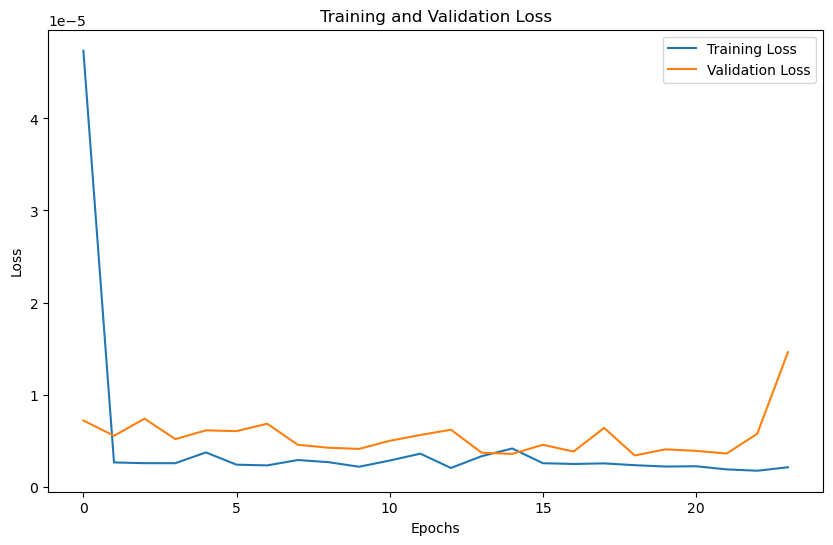

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [32]:
gru_pred = model_gru.predict(X_test)

gru_pred = scaler.inverse_transform(gru_pred)
gru_test = scaler.inverse_transform(y_test.reshape(-1, 1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [ ]:
print("Mean Square Error :", round(mean_squared_error(gru_test, gru_pred), 2))
print("Mean Absolute Error:", round(mean_absolute_error(gru_test, gru_pred), 2))
print("Root Mean Square Error :", np.sqrt(np.mean(gru_test - gru_pred)**2).round(2))
print("Mean Absolute Percentage Error :", round(mean_absolute_percentage_error(gru_test,gru_pred), 2))

MSE: 908.78
MAE: 20.05
Root Mean Square Error : 5.44
Mean Absolute Percentage Error : 0.04


In [34]:
train = df.iloc[:train_size , 0:1]
test = df.iloc[train_size: , 0:1]
test['GRU Prediction'] = gru_pred

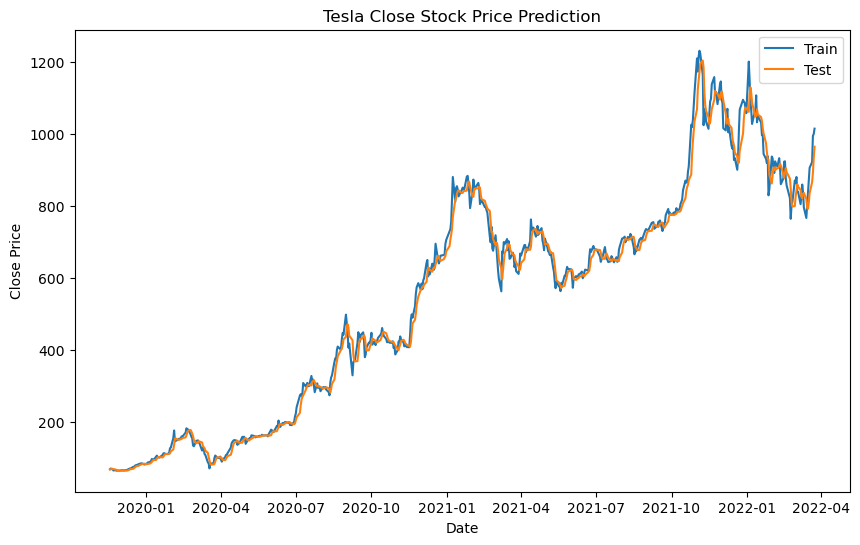

In [35]:
plt.figure(figsize= (10, 6))
plt.title('Tesla Close Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(test['Close'])
plt.plot(test['GRU Prediction'])
plt.legend(['Train', 'Test', 'GRU Prediction'])

**Insight**

Grafik menunjukkan kurva loss yang menurun dan konvergen antara data training dan validation, menandakan bahwa model GRU stabil dan tidak mengalami overfitting.

Nilai MSE model GRU cukup besar, yang menunjukkan bahwa terdapat deviasi yang cukup signifikan dalam beberapa prediksi. Namun, MSE sangat sensitif terhadap outlier sehingga nilai ini bisa terpengaruh oleh prediksi yang jauh dari nilai sebenarnya.

MAE memberikan nilai rata-rata dari kesalahan absolut antara prediksi dan data aktual. Nilai MAE sebesar 20.05 berarti secara rata-rata model membuat kesalahan sebesar ±20 unit dari harga aktual. Nilai ini cukup informatif untuk mengetahui seberapa besar deviasi model secara umum tanpa dipengaruhi oleh outlier secara ekstrem.

RMSE adalah akar dari MSE dan memiliki satuan yang sama dengan data asli. Nilai RMSE sebesar 5.44 mengindikasikan bahwa deviasi rata-rata model terhadap nilai aktual adalah sekitar 5.44 unit. Ini memberi gambaran yang cukup akurat tentang seberapa baik model mampu menangkap pola dalam data.

MAPE mengukur kesalahan dalam bentuk persentase dari nilai aktual. Nilai MAPE sebesar 0.04 atau 4% menunjukkan bahwa model GRU mampu melakukan prediksi dengan tingkat kesalahan rata-rata sebesar 4% dari nilai aktual. Ini merupakan nilai yang sangat baik dalam konteks pemodelan time series harga saham, karena menunjukkan bahwa model cukup presisi dan andal.

## **Kesimpulan**

Melalui perbandingan metrik evaluasi antara hasil permodelan dengan LSTM dan GRU dapat disimpulkan bahwa Model GRU menghasilkan performa yang lebih baik dibandingkan LSTM berdasarkan semua metrik evaluasi. Nilai MSE dan MAE GRU lebih rendah, yang berarti kesalahan prediksinya lebih kecil secara absolut maupun kuadrat. MAPE GRU sebesar 4% mengindikasikan bahwa rata-rata prediksi hanya meleset sebesar 4% dari nilai aktual, dibandingkan 7% pada LSTM. RMSE GRU juga menunjukkan bahwa sebaran kesalahan lebih kecil dibandingkan LSTM. Dengan mempertimbangkan semua hasil di atas, model GRU lebih unggul dalam memprediksi harga saham Tesla dan lebih disarankan untuk digunakan dalam implementasi lebih lanjut. Performa yang baik ini juga membuka kemungkinan untuk meningkatkan akurasi dengan tuning tambahan atau penggabungan metode lain (ensemble, hybrid, dsb.).